In [1]:
import torch
import math
from torch import nn
import pandas as pd
import numpy as np
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# define class for scale mixture gaussian prior
class ScaleMixtureGaussian:                               
    def __init__(self, mixture_weight, stddev_1, stddev_2):
        super().__init__()
        # mixture_weight is the weight for the first gaussian
        self.mixture_weight = mixture_weight
        # stddev_1 and stddev_2 are the standard deviations for the two gaussians
        self.stddev_1 = stddev_1
        self.stddev_2 = stddev_2
        # create two normal distributions with the specified standard deviations
        self.gaussian1 = torch.distributions.Normal(0,stddev_1)
        self.gaussian2 = torch.distributions.Normal(0,stddev_2)


    def log_prob(self, x):
        prob1 = torch.exp(self.gaussian1.log_prob(x))
        prob2 = torch.exp(self.gaussian2.log_prob(x))
        return (torch.log(self.mixture_weight * prob1 + (1-self.mixture_weight) * prob2)).sum()
    
# define class for gaussian node
class GaussianNode:
    def __init__(self, mean, rho_param):
        super().__init__()
        self.mean = mean
        self.rho_param = rho_param
        self.normal = torch.distributions.Normal(0,1)
    
    # Calculate the standard deviation from the rho parameter
    def sigma(self):
        return torch.log1p(torch.exp(self.rho_param))

    # Sample from the Gaussian node
    def sample(self):
        epsilon = self.normal.sample(self.rho_param.size()).cuda()
        return self.mean + self.sigma() * epsilon
    
    # Calculate the KL divergence between the prior and the variational posterior
    def log_prob(self, x):
        return (-math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma()) - ((x - self.mean) ** 2) / (2 * self.sigma() ** 2)).sum()

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, mu_init, rho_init, prior_init):
        super().__init__()

        # Initialize the parameters for the weights and biases
        self.weight_mean = nn.Parameter(torch.empty(out_features, in_features).uniform_(*mu_init))
        self.weight_rho_param = nn.Parameter(torch.empty(out_features, in_features).uniform_(*rho_init))
        self.weight = GaussianNode(self.weight_mean, self.weight_rho_param)

        self.bias_mean = nn.Parameter(torch.empty(out_features).uniform_(*mu_init))
        self.bias_rho_param = nn.Parameter(torch.empty(out_features).uniform_(*rho_init))
        self.bias = GaussianNode(self.bias_mean, self.bias_rho_param)
        
        self.weight_prior = ScaleMixtureGaussian(prior_init[0], math.exp(prior_init[1]), math.exp(prior_init[2]))
        self.bias_prior = ScaleMixtureGaussian(prior_init[0], math.exp(prior_init[1]), math.exp(prior_init[2]))

        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, x):
        weight = self.weight.sample()
        bias = self.bias.sample()

        return nn.functional.linear(x, weight, bias)

class BayesianNetwork(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']
        self.mu_init = model_params['mu_init']
        self.rho_init = model_params['rho_init']
        self.prior_init = model_params['prior_init']

        self.fc1 = BayesianLinear(self.input_shape, self.hidden_units, self.mu_init, self.rho_init, self.prior_init)
        self.fc1_activation = nn.ReLU()
        self.fc2 = BayesianLinear(self.hidden_units, self.hidden_units, self.mu_init, self.rho_init, self.prior_init)
        self.fc2_activation = nn.ReLU()
        self.fc3 = BayesianLinear(self.hidden_units, self.classes, self.mu_init, self.rho_init, self.prior_init)
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape) # Flatten images
        x = self.fc1_activation(self.fc1(x))
        x = self.fc2_activation(self.fc2(x))
        x = self.fc3(x)
        return x

    def log_prior(self):
        return self.fc1.log_prior + self.fc2.log_prior + self.fc3.log_prior
    
    def log_variational_posterior(self):
        return self.fc1.log_variational_posterior + self.fc2.log_variational_posterior + self.fc3.log_variational_posterior


    def get_nll(self, outputs, target, sigma=1.):
        if self.experiment == 'regression': #  -(.5 * (target - outputs) ** 2).sum()
            nll = -torch.distributions.Normal(outputs, sigma).log_prob(target).sum()
        elif self.experiment == 'classification':
            nll = nn.CrossEntropyLoss(reduction='sum')(outputs, target)
        return nll

    def sample_elbo(self, x, target, beta, samples, sigma=1.):
        log_prior = torch.zeros(1).to(device)
        log_variational_posterior = torch.zeros(1).to(device)
        negative_log_likelihood = torch.zeros(1).to(device)

        for i in range(samples):
            output = self.forward(x)
            log_prior += self.log_prior()
            log_variational_posterior += self.log_variational_posterior()
            negative_log_likelihood += self.get_nll(output, target, sigma)

        log_prior = beta*(log_prior / samples)
        log_variational_posterior = beta*(log_variational_posterior / samples) 
        negative_log_likelihood = negative_log_likelihood / samples
        loss = log_variational_posterior - log_prior + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood    


In [3]:
class MLP(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']

        self.net = nn.Sequential(
            nn.Linear(self.input_shape, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, self.classes))
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape) # Flatten images
        
        x = self.net(x)
        return x

class MLP_Dropout(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        self.input_shape = model_params['input_shape']
        self.classes = model_params['classes']
        self.batch_size = model_params['batch_size']
        self.hidden_units = model_params['hidden_units']
        self.experiment = model_params['experiment']

        self.net = nn.Sequential(
            nn.Linear(self.input_shape, self.hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_units, self.hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_units, self.classes))
    
    def forward(self, x):
        if self.experiment == 'classification':
            x = x.view(-1, self.input_shape) # Flatten images
       
        x = self.net(x)
        return x

    def enable_dropout(self):
        ''' Enable the dropout layers during test-time '''
        for m in self.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()

In [4]:
class RegConfig:
    # save_dir = './saved_models'
    train_size = 1024
    batch_size = 128
    lr = 1e-3
    epochs = 100 #1000
    train_samples = 5                   # number of train samples for MC gradients
    test_samples = 10                   # number of test samples for MC averaging
    num_test_points = 400               # number of test points
    experiment = 'regression'
    hidden_units = 400                  # number of hidden units
    noise_tolerance = .1                # log likelihood sigma
    mu_init = [-0.2, 0.2]               # range for mean 
    rho_init = [-5, -4]                 # range for rho_param
    prior_init = [0.5, -0, -6]        # mixture weight, log(stddev_1), log(stddev_2)
   

class RLConfig:
    data_dir = '/kaggle/input/mushroom-dataset/mushroom/agaricus-lepiota.data'
    batch_size = 64
    num_batches = 64
    buffer_size = batch_size * num_batches  # buffer to track latest batch of mushrooms
    lr = 1e-4
    training_steps = 10000
    experiment = 'regression'
    hidden_units = 100                      # number of hidden units
    mu_init = [-0.2, 0.2]                   # range for mu 
    rho_init = [-5, -4]                     # range for rho
    prior_init = [0.5, -0, -6]               # mixture weight, log(stddev_1), log(stddev_2)

class ClassConfig:
    batch_size = 128
    lr = 1e-3 # 1e-5 fa schifo, 1e-4 parte da 8% errore, 1e-3 parte da 5%
    epochs = 600 #100
    hidden_units = 1200
    experiment = 'classification'
    dropout = True
    train_samples = 1 # 10 è troppo lento
    test_samples = 10
    x_shape = 28 * 28                       # x shape
    classes = 10                            # number of output classes
    mu_init = [-0.2, 0.2]                   # range for mean 
    rho_init = [-5, -4]                     # range for rho_param
    prior_init = [0.75, 0, -7]             # mixture weight, log(stddev_1), log(stddev_2)

In [5]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y # vedere

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def read_data_rl(data_dir):
    '''
    Read in data for contextual bandits
    - transform context and label to one-hot encoded vectors
    '''
    df = pd.read_csv(data_dir, sep=',', header=None)
    df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
         'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
         'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
         'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']
    X = pd.DataFrame(df, columns=df.columns[1:len(df.columns)], index=df.index)
    Y = df['class']

    # transform to one-hot encoding
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(Y)
    Y_ = label_encoder.transform(Y)
    X_ = X.copy()
    for feature in X.columns:
        label_encoder.fit(X[feature])
        X_[feature] = label_encoder.transform(X[feature])

    oh_encoder = preprocessing.OneHotEncoder()
    oh_encoder.fit(X_)
    X_ = oh_encoder.transform(X_).toarray()

    return X_, Y_

def create_data_reg(train_size):
    np.random.seed(0)
    xs = np.random.uniform(low=0., high=0.6, size=train_size)
    
    eps = np.random.normal(loc=0., scale=0.02, size=[train_size])

    ys = xs + 0.3 * np.sin(2*np.pi * (xs + eps)) + 0.3 * np.sin(4*np.pi * (xs + eps)) + eps

    xs = torch.from_numpy(xs).reshape(-1,1).float()
    ys = torch.from_numpy(ys).reshape(-1,1).float()

    return xs, ys

In [6]:
# def load_bnn_class_model(saved_model):
#     config = ClassConfig

#     model_params = {
#         'input_shape': config.x_shape,
#         'classes': config.classes,
#         'batch_size': config.batch_size,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'mu_init': config.mu_init,
#         'rho_init': config.rho_init,
#         'prior_init': config.prior_init
#     }
#     model = BayesianNetwork(model_params)
#     model.load_state_dict(torch.load(saved_model))

#     return model.eval()

# def load_mlp_class_model(saved_model):
#     config = ClassConfig
#     model_params = {
#         'input_shape': config.x_shape,
#         'classes': config.classes,
#         'batch_size': config.batch_size,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#     }
#     model = MLP(model_params)
#     model.load_state_dict(torch.load(saved_model))

#     return model.eval()

# def load_dropout_class_model(saved_model):
#     config = ClassConfig
#     model_params = {
#         'input_shape': config.x_shape,
#         'classes': config.classes,
#         'batch_size': config.batch_size,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'dropout': True
#     }
#     model = MLP_Dropout(model_params)
#     model.load_state_dict(torch.load(saved_model))

#     return model.eval()

In [7]:
def create_regression_plot(X_test, y_test, train_ds):
    fig = plt.figure(figsize=(9, 6))
    plt.plot(X_test, np.median(y_test, axis=0), label='Median Posterior Predictive')
    
    # Range
    plt.fill_between(
        X_test.reshape(-1), 
        np.percentile(y_test, 0, axis=0), 
        np.percentile(y_test, 100, axis=0), 
        alpha = 0.2, color='orange', label='Range') #color='blue',
    
    # interquartile range
    plt.fill_between(
        X_test.reshape(-1), 
        np.percentile(y_test, 25, axis=0), 
        np.percentile(y_test, 75, axis=0), 
        alpha = 0.4,  label='Interquartile Range') #color='red',
    
    plt.scatter(train_ds.dataset.X, train_ds.dataset.y, label='Training data', marker='x', alpha=0.5, color='k', s=2)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylim([-1.5, 1.5])
    plt.xlim([-0.6, 1.4])

   

In [8]:
class BNN_Classification():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.n_samples = parameters['train_samples']
        self.test_samples = parameters['test_samples']
        self.x_shape = parameters['x_shape']
        self.classes = parameters['classes']
        self.mu_init = parameters['mu_init']
        self.rho_init = parameters['rho_init']
        self.prior_init = parameters['prior_init']
        self.best_acc = 0.
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.classes,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment,
            'mu_init': self.mu_init,
            'rho_init': self.rho_init,
            'prior_init': self.prior_init,
        }
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=100, gamma=0.5)
        # print(f'Classification Task {self.label} Parameters: ')
        # print(f'number of samples: {self.n_samples}')
        # print("BNN Parameters: ")
        # print(f'batch size: {self.batch_size}, x shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def train_step(self, train_data):
        self.net.train()
        for idx, (x, y) in enumerate(tqdm(train_data)):
            beta = 2 ** (self.num_batches - (idx + 1)) / (2 ** self.num_batches - 1) 
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = self.net.sample_elbo(x, y, beta, self.n_samples)            
            net_loss = self.loss_info[0]
            net_loss.backward()
            self.optimiser.step()

    def predict(self, X):
        probs = torch.zeros(size=[self.batch_size, self.classes]).to(device)
        for _ in torch.arange(self.test_samples):
            out = torch.nn.Softmax(dim=1)(self.net(X))
            probs = probs + out / self.test_samples
        preds = torch.argmax(probs, dim=1)
        return preds, probs

    def evaluate(self, test_loader):
        self.net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(test_loader):
                X, y = data
                X, y = X.to(device), y.to(device)
                preds, _ = self.predict(X)
                total += self.batch_size
                correct += (preds == y).sum().item()
        self.acc = correct / total
        print(f'{self.label} validation accuracy: {self.acc}')  
        return self.acc


In [9]:
class MLP_Classification():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.x_shape = parameters['x_shape']
        self.classes = parameters['classes']
        self.best_acc = 0.
        self.dropout = parameters['dropout']
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.classes,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment,
            'dropout': self.dropout,
        }
        self.net = MLP_Dropout(model_params).to(device)  
        self.optimiser = torch.optim.SGD(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=100, gamma=0.5)

    def train_step(self, train_data):
        self.net.train()
        for _, (x, y) in enumerate(tqdm(train_data)):
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = torch.nn.functional.cross_entropy(self.net(x), y, reduction='sum')
            self.loss_info.backward()
            self.optimiser.step()

    def predict(self, X):
        probs = torch.nn.Softmax(dim=1)(self.net(X))
        preds = torch.argmax(probs, dim=1)
        return preds, probs

    def evaluate(self, test_loader):
        self.net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(test_loader):
                X, y = data
                X, y = X.to(device), y.to(device)
                preds, _ = self.predict(X)
                total += self.batch_size
                correct += (preds == y).sum().item()
        self.acc = correct / total
        print(f'{self.label} validation accuracy: {self.acc}') 
        return self.acc

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt

def class_trainer():
    config = ClassConfig
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 255 / 126.),
    ])

    train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

    # valid_size = 1 / 6
    # num_train = len(train_data)
    # indices = list(range(num_train))
    # split = int(valid_size * num_train)
    # train_idx, valid_idx = indices[split:], indices[:split]

    # train_sampler = SubsetRandomSampler(train_idx)
    # valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.batch_size, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.batch_size, shuffle=False, drop_last=True)

    params = {
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'dropout': config.dropout,
        'batch_size': config.batch_size,
        'epochs': config.epochs,
        'x_shape': config.x_shape,
        'classes': config.classes,
        'num_batches': len(train_loader),
        'train_samples': config.train_samples,
        'test_samples': config.test_samples,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init,
    }

    # Instantiate both models
    bnn_model = BNN_Classification('bnn_classification', {**params})
    mlp_model = MLP_Classification('mlp_classification', {**params})

    bnn_test_errors = []
    mlp_test_errors = []

    epochs = config.epochs
    for epoch in range(epochs):
        print(f'--- Epoch {epoch+1}/{epochs} ---')

        # Train both models
        bnn_model.train_step(train_loader)
        mlp_model.train_step(train_loader)

        # Evaluate on test set
        bnn_test_acc = bnn_model.evaluate(test_loader)
        mlp_test_acc = mlp_model.evaluate(test_loader)

        bnn_test_error = 100 * (1 - bnn_test_acc)
        mlp_test_error = 100 * (1 - mlp_test_acc)

        bnn_test_errors.append(bnn_test_error)
        mlp_test_errors.append(mlp_test_error)

        print(f'BNN Test Error: {bnn_test_error:.2f}%')
        print(f'MLP Test Error: {mlp_test_error:.2f}%')

        # Learning rate scheduler step if defined
        bnn_model.scheduler.step()
        mlp_model.scheduler.step()

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(bnn_test_errors, label='BNN Test Error')
    plt.plot(mlp_test_errors, label='MLP Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Test Error (%)')
    plt.title('BNN vs MLP Test Error on MNIST')
    plt.legend()
    plt.grid(True)
    
    # Set x-axis ticks every 5 epochs
    epochs = len(bnn_test_errors)
    plt.xticks(ticks=range(0, epochs, 5))
    
    plt.tight_layout()
    plt.show()


#class_trainer()





In [11]:
# search_config = {
#     'batch_size': [128],
#     'lr': [1e-3, 1e-4],
#     'epochs': [10],
#     'hidden_units': [1200],
#     'experiment': ['classification'],
#     'dropout': [False],
#     'train_samples': [1, 2, 5],
#     'test_samples': [10],
#     'x_shape': [28 * 28],
#     'classes': [10],
#     'mu_init': [[-0.2, 0.2]],
#     'rho_init': [[-5, -4]],
#     'prior_init': [
#         [0.25, -0, -6],
#         [0.25, -0, -7], 
#         [0.25, -1, -6], 
#         [0.25, -1, -7], 
#         [0.75, -0, -6],
#         [0.75, -0, -7], 
#         [0.75, -1, -6], 
#         [0.75, -1, -7],       
#     ]
# }

# # search_config = {
# #     'batch_size': [128],
# #     'lr': [1e-3, 1e-4],
# #     'epochs': [1], #10
# #     'hidden_units': [1200],
# #     'experiment': ['classification'],
# #     'dropout': [False],
# #     'train_samples': [1],
# #     'test_samples': [10],
# #     'x_shape': [28 * 28],
# #     'classes': [10],
# #     'mu_init': [[-0.2, 0.2]],
# #     'rho_init': [[-5, -4]],
# #     'prior_init': [
# #         [0.25, -0, -6],        
# #     ]
# # }


# import itertools
# from copy import deepcopy

# def generate_param_combinations(param_grid):
#     keys = list(param_grid.keys())
#     values = list(param_grid.values())
#     for combo in itertools.product(*values):
#         yield dict(zip(keys, combo))


# def class_trainer(config):
    
#     transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Lambda(lambda x: x * 255 / 126.),  # divide as in paper, * 255 gives better results
#         ])

#     train_data = datasets.MNIST(
#             root='data',
#             train=True,
#             download=True,
#             transform=transform)
#     # test_data = datasets.MNIST(
#     #         root='data',
#     #         train=False,
#     #         download=True,
#     #         transform=transform)

#     valid_size = 1 / 6

#     num_train = len(train_data)
#     indices = list(range(num_train))
#     split = int(valid_size * num_train)
#     train_idx, valid_idx = indices[split:], indices[:split]

#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(valid_idx)


#     train_loader = torch.utils.data.DataLoader(
#             train_data,
#             batch_size=config['batch_size'],
#             sampler=train_sampler,
#             drop_last=True)
#     valid_loader = torch.utils.data.DataLoader(
#             train_data,
#             batch_size=config['batch_size'],
#             sampler=valid_sampler,
#             drop_last=True)
#     # test_loader = torch.utils.data.DataLoader(
#     #         test_data,
#     #         batch_size=config.batch_size,
#     #         shuffle=False,
#     #         drop_last=True)

#     params = deepcopy(config)
#     params['num_batches'] = len(train_loader)

#     model = BNN_Classification('bnn_classification', {**params})
#     #model = MLP_Classification('mlp_classification', {**params})
    
#     epochs = config['epochs']
#     for epoch in range(epochs):
#             print(f'Epoch {epoch+1}/{epochs}')
#             model.train_step(train_loader)
#             valid_acc = model.evaluate(valid_loader)
#             print('Valid Error', round(100 * (1 - valid_acc), 3), '%',)
#             model.scheduler.step()
#             if model.acc > model.best_acc:
#                 model.best_acc = model.acc
                

#     return model.best_acc, model


In [12]:
# best_val_acc = 0.0
# best_config = None
# best_model = None

# for config in generate_param_combinations(search_config):
#     print(f"Trying config: {config}")
#     val_acc, model = class_trainer(config)

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_config = deepcopy(config)
#         best_model = model

# print("Best Config:")
# print(best_config)
# print(f"Best Validation Accuracy: {best_val_acc:.4f}")

In [13]:
# from tqdm import tqdm
# import numpy as np
# import torch
# from torch.utils.data import SubsetRandomSampler
# from torchvision import datasets, transforms
# from itertools import product

# def class_trainer(config):

#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Lambda(lambda x: x * 255. / 126.),
#     ])

#     train_data = datasets.MNIST(
#         root='data',
#         train=True,
#         download=True,
#         transform=transform)
#     test_data = datasets.MNIST(
#         root='data',
#         train=False,
#         download=True,
#         transform=transform)

#     valid_size = 1 / 6
#     num_train = len(train_data)
#     indices = list(range(num_train))
#     split = int(valid_size * num_train)
#     train_idx, valid_idx = indices[split:], indices[:split]

#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(valid_idx)

#     train_loader = torch.utils.data.DataLoader(
#         train_data,
#         batch_size=config['batch_size'],
#         sampler=train_sampler,
#         drop_last=True)
#     valid_loader = torch.utils.data.DataLoader(
#         train_data,
#         batch_size=config['batch_size'],
#         sampler=valid_sampler,
#         drop_last=True)
#     test_loader = torch.utils.data.DataLoader(
#         test_data,
#         batch_size=config['batch_size'],
#         shuffle=False,
#         drop_last=True)

#     params = {
#         'lr': config['lr'],
#         'hidden_units': config['hidden_units'],
#         'experiment': config['experiment'],
#         'batch_size': config['batch_size'],
#         'epochs': config['epochs'],
#         'x_shape': config['x_shape'],
#         'classes': config['classes'],
#         'num_batches': len(train_loader),
#         'train_samples': config['train_samples'],
#         'test_samples': config['test_samples'],
#         'mu_init': config['mu_init'],
#         'rho_init': config['rho_init'],
#         'prior_init': config['prior_init'],
#     }

#     model = BNN_Classification('bnn_classification', {**params, 'dropout': False})

#     best_val_acc = 0
#     for epoch in range(config['epochs']):
#         print(f'Epoch {epoch + 1}/{config["epochs"]}')
#         model.train_step(train_loader)
#         valid_acc = model.evaluate(valid_loader)
#         print('Valid Error', round(100 * (1 - valid_acc), 3), '%')
#         model.scheduler.step()
#         if model.acc > model.best_acc:
#             model.best_acc = model.acc
#             best_val_acc = valid_acc
#             # torch.save(model.net.state_dict(), "best_model.pt")

#     return best_val_acc


In [14]:
# def run_grid_search():
#     # Define the grid
#     param_grid = {
#         'lr': [1e-3, 1e-4],
#         'batch_size': [64, 128],
#         'hidden_units': [128, 256],
#     }

#     # Fixed config options
#     base_config = {
#         'experiment': 'grid_search',
#         'epochs': 5,
#         'x_shape': (1, 28, 28),
#         'classes': 10,
#         'train_samples': 60000,
#         'test_samples': 10000,
#         'mu_init': 0,
#         'rho_init': -3,
#         'prior_init': 0,
#     }

#     best_acc = 0
#     best_params = None

#     # Iterate over all combinations
#     for lr, batch_size, hidden_units in product(param_grid['lr'], param_grid['batch_size'], param_grid['hidden_units']):
#         config = {
#             **base_config,
#             'lr': lr,
#             'batch_size': batch_size,
#             'hidden_units': hidden_units
#         }

#         print(f"\nRunning with config: {config}")
#         acc = class_trainer(config)

#         if acc > best_acc:
#             best_acc = acc
#             best_params = config

#     print(f"Best Validation Accuracy: {best_acc:.4f}")
#     print(f"Best Config: {best_params}")

# run_grid_search()

In [15]:
class BNN_Regression():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.n_samples = parameters['train_samples']
        self.test_samples = parameters['test_samples']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.noise_tol = parameters['noise_tolerance']
        self.lr = parameters['lr']
        self.best_loss = np.inf
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment'],
            'mu_init': parameters['mu_init'],
            'rho_init': parameters['rho_init'],
            'prior_init': parameters['prior_init']
        }
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=500, gamma=0.5)
        # print(f'Regression Task {self.label} Parameters: ')
        # print(f'number of samples: {self.n_samples}, noise tolerance: {self.noise_tol}')
        print("BNN Parameters: ")
        print(f'batch size: {self.batch_size}, x shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, mu_init: {parameters["mu_init"]}, rho_init: {parameters["rho_init"]}, prior_init: {parameters["prior_init"]}, lr: {self.lr}')

    def train_step(self, train_data):
        self.net.train()
        for idx, (x, y) in enumerate(train_data):
            beta = 2 ** (self.num_batches - (idx + 1)) / (2 ** self.num_batches - 1) 
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = self.net.sample_elbo(x, y, beta, self.n_samples, sigma=self.noise_tol)
            net_loss = self.loss_info[0]
            net_loss.backward()
            self.optimiser.step()
        self.epoch_loss = net_loss.item()

    def evaluate(self, x_test):
        self.net.eval()
        with torch.no_grad():
            y_test = np.zeros((self.test_samples, x_test.shape[0]))
            for s in range(self.test_samples):
                tmp = self.net(x_test.to(device)).detach().cpu().numpy()
                y_test[s,:] = tmp.reshape(-1)
            return y_test

In [16]:
class MLP_Regression():
    def __init__(self, label, parameters):
        super().__init__()
        self.label = label
        self.lr = parameters['lr']
        self.hidden_units = parameters['hidden_units']
        self.experiment = parameters['experiment']
        self.batch_size = parameters['batch_size']
        self.num_batches = parameters['num_batches']
        self.x_shape = parameters['x_shape']
        self.y_shape = parameters['y_shape']
        self.best_loss = np.inf
        self.init_net(parameters)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x_shape,
            'classes': self.y_shape,
            'batch_size': self.batch_size,
            'hidden_units': self.hidden_units,
            'experiment': self.experiment
        }
        self.net = MLP(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print("MLP Parameters: ")
        print(f'batch size: {self.batch_size}, input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def train_step(self, train_data):
        self.net.train()
        for _, (x, y) in enumerate(train_data):
            x, y = x.to(device), y.to(device)
            self.net.zero_grad()
            self.loss_info = torch.nn.functional.mse_loss(self.net(x), y, reduction='sum')
            self.loss_info.backward()
            self.optimiser.step()

        self.epoch_loss = self.loss_info.item()

    def evaluate(self, x_test):
        self.net.eval()
        with torch.no_grad():
            y_test = self.net(x_test.to(device)).detach().cpu().numpy()
            return y_test

In [17]:
# def reg_trainer():
#     config = RegConfig
#     X, Y = create_data_reg(train_size=config.train_size)
#     train_loader = PrepareData(X, Y)
#     train_loader = DataLoader(train_loader, batch_size=config.batch_size, shuffle=True)

#     params = {
#         'lr': config.lr,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'batch_size': config.batch_size,
#         'num_batches': len(train_loader),
#         'x_shape': X.shape[1],
#         'y_shape': Y.shape[1],
#         'train_samples': config.train_samples,
#         'test_samples': config.test_samples,
#         'noise_tolerance': config.noise_tolerance,
#         'mu_init': config.mu_init,
#         'rho_init': config.rho_init,
#         'prior_init': config.prior_init,
#     }

#     model = BNN_Regression('bnn_regression', {**params})
#     #model = MLP_Regression('mlp_regression', {**params})

#     epochs = config.epochs
#     print(f"Initialising training on {device}...")

#     # training loop
#     for epoch in tqdm(range(epochs)):
    
#         model.train_step(train_loader)
#         model.scheduler.step()
#         # save best model
#         if model.epoch_loss < model.best_loss:
#             model.best_loss = model.epoch_loss
#             # torch.save(model.net.state_dict(), model.save_model_path)

#     # evaluate
#     print("Evaluating and generating plots...")
#     x_test = torch.linspace(-2., 2, config.num_test_points).reshape(-1, 1)
    
#     # model.net.load_state_dict(torch.load(model.save_model_path, map_location=torch.device(device)))
#     y_test = model.evaluate(x_test)
    
#     #create_regression_plot(x_test.cpu().numpy(), y_test.reshape(1, -1), train_loader) #per mlp regression
   
#     create_regression_plot(x_test.cpu().numpy(), y_test, train_loader)


# reg_trainer()

In [18]:
# def reg_trainer():
#     config = RegConfig
#     X, Y = create_data_reg(train_size=config.train_size)
#     train_loader = PrepareData(X, Y)
#     train_loader = DataLoader(train_loader, batch_size=config.batch_size, shuffle=True)

#     params = {
#         'lr': config.lr,
#         'hidden_units': config.hidden_units,
#         'experiment': config.experiment,
#         'batch_size': config.batch_size,
#         'num_batches': len(train_loader),
#         'x_shape': X.shape[1],
#         'y_shape': Y.shape[1],
#         'train_samples': config.train_samples,
#         'test_samples': config.test_samples,
#         'noise_tolerance': config.noise_tolerance,
#         'mu_init': config.mu_init,
#         'rho_init': config.rho_init,
#         'prior_init': config.prior_init,
#     }

#     #model = BNN_Regression('bnn_regression', {**params})
#     model = MLP_Regression('mlp_regression', {**params})

#     epochs = config.epochs
#     print(f"Initialising training on {device}...")

#     # training loop
#     for epoch in tqdm(range(epochs)):
    
#         model.train_step(train_loader)
#         model.scheduler.step()
#         # save best model
#         if model.epoch_loss < model.best_loss:
#             model.best_loss = model.epoch_loss
#             # torch.save(model.net.state_dict(), model.save_model_path)

#     # evaluate
#     print("Evaluating and generating plots...")
#     x_test = torch.linspace(-2., 2, config.num_test_points).reshape(-1, 1)
    
#     # model.net.load_state_dict(torch.load(model.save_model_path, map_location=torch.device(device)))
#     y_test = model.evaluate(x_test)
    
#     create_regression_plot(x_test.cpu().numpy(), y_test.reshape(1, -1), train_loader) #per mlp regression
   
#     #create_regression_plot(x_test.cpu().numpy(), y_test, train_loader)


# reg_trainer()

In [19]:
'''
Defines base class for contextual bandits
'''
import torch
import numpy as np



class Bandit():
    def __init__(self, label, bandit_params, x, y):
        self.n_samples = bandit_params['n_samples']
        self.buffer_size = bandit_params['buffer_size']
        self.batch_size = bandit_params['batch_size']
        self.num_batches = bandit_params['num_batches']
        self.lr = bandit_params['lr']
        self.epsilon = bandit_params['epsilon']
        self.cumulative_regrets = [0]
        self.buffer_x, self.buffer_y = [], []
        self.x, self.y = x, y
        self.label = label
        self.init_net(bandit_params)
        self.tp, self.tn, self.fp, self.fn = 0, 0, 0, 0

    def get_agent_reward(self, eaten, edible):
        if not eaten:
            return 0
        if eaten and edible:
            return 5
        elif eaten and not edible:
            return 5 if np.random.rand() > 0.5 else -35

    def get_oracle_reward(self, edible):
        return 5*edible 

    def take_action(self, mushroom):
        context, edible = self.x[mushroom], self.y[mushroom]
        eat_tuple = torch.FloatTensor(np.concatenate((context, [1, 0]))).unsqueeze(0).to(device)
        reject_tuple = torch.FloatTensor(np.concatenate((context, [0, 1]))).unsqueeze(0).to(device)

        # evaluate reward for actions
        with torch.no_grad():
            self.net.eval()
            reward_eat = sum([self.net(eat_tuple) for _ in range(self.n_samples)]).item()
            reward_reject = sum([self.net(reject_tuple) for _ in range(self.n_samples)]).item()

        eat = reward_eat > reward_reject
        # epsilon-greedy agent
        if np.random.rand() < self.epsilon:
            eat = (np.random.rand() < 0.5)
        agent_reward = self.get_agent_reward(eat, edible)

        # record bandit action
        if edible and eat:
            self.tp += 1
        elif edible and not eat:
            self.fn += 1
        elif not edible and eat:
            self.fp += 1
        else:
            self.tn += 1

        # record context, action, reward
        action = torch.Tensor([1, 0] if eat else [0, 1])
        self.buffer_x.append(np.concatenate((context, action)))
        self.buffer_y.append(agent_reward)

        # calculate regret
        regret = self.get_oracle_reward(edible) - agent_reward
        self.cumulative_regrets.append(self.cumulative_regrets[-1]+regret)

    def update(self, mushroom):
        self.take_action(mushroom)
        l = len(self.buffer_x)

        if l <= self.batch_size:
            idx_pool = int(self.batch_size//l + 1)*list(range(l))
            idx_pool = np.random.permutation(idx_pool[-self.batch_size:])
        elif l > self.batch_size and l < self.buffer_size:
            idx_pool = int(l//self.batch_size)*self.batch_size
            idx_pool = np.random.permutation(list(range(l))[-idx_pool:])
        else:
            idx_pool = np.random.permutation(list(range(l))[-self.buffer_size:])

        context_pool = torch.Tensor([self.buffer_x[i] for i in idx_pool]).to(device)
        value_pool = torch.Tensor([self.buffer_y[i] for i in idx_pool]).to(device)
        
        for i in range(0, len(idx_pool), self.batch_size):
            self.loss_info = self.loss_step(context_pool[i:i+self.batch_size], value_pool[i:i+self.batch_size], i//self.batch_size)


In [20]:
'''
Two Contextual bandits 
1) BNN and Thompson Sampling -> BNN_Bandit
2) MLP and epsilon-greedy poligy -> Greedy_Bandit
Both derived from base_bandit.py class
'''
import torch
import numpy as np

class BNN_Bandit(Bandit):
    def __init__(self, label, *args):
        super().__init__(label, *args)

    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x.shape[1]+2,
            'classes': 1 if len(self.y.shape)==1 else self.y.shape[1],
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment'],
            'mu_init': parameters['mu_init'],
            'rho_init': parameters['rho_init'],
            'prior_init': parameters['prior_init']
        }
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print(f'Bandit {self.label} Parameters: ')
        print(f'buffer_size: {self.buffer_size}, batch size: {self.batch_size}, number of samples: {self.n_samples}, epsilon: {self.epsilon}')
        print("BNN Parameters: ")
        print(f'input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def loss_step(self, x, y, batch_id):
        beta = 2 ** (self.num_batches - (batch_id + 1)) / (2 ** self.num_batches - 1) 
        self.net.train()
        self.net.zero_grad()
        loss_info = self.net.sample_elbo(x, y, beta, self.n_samples)
        net_loss = loss_info[0]
        net_loss.backward()
        self.optimiser.step()
        return loss_info


class Greedy_Bandit(Bandit):
    def __init__(self, label, *args):
        super().__init__(label, *args)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x.shape[1]+2,
            'classes': 1 if len(self.y.shape)==1 else self.y.shape[1],
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment']
        }
        self.net = MLP(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print(f'Bandit {self.label} Parameters: ')
        print(f'buffer_size: {self.buffer_size}, batch size: {self.batch_size}, number of samples: {self.n_samples}, epsilon: {self.epsilon}')
        print("MLP Parameters: ")
        print(f'input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def loss_step(self, x, y, batch_id):
        self.net.train()
        self.net.zero_grad()
        net_loss = torch.nn.functional.mse_loss(self.net(x).squeeze(), y, reduction='sum')
        net_loss.backward()
        self.optimiser.step()
        return net_loss

Bandit bnn_bandit Parameters: 
buffer_size: 4096, batch size: 64, number of samples: 2, epsilon: 0
BNN Parameters: 
input shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Bandit greedy_bandit Parameters: 
buffer_size: 4096, batch size: 64, number of samples: 1, epsilon: 0
MLP Parameters: 
input shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Bandit greedy_bandit_001 Parameters: 
buffer_size: 4096, batch size: 64, number of samples: 1, epsilon: 0.01
MLP Parameters: 
input shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Bandit greedy_bandit_005 Parameters: 
buffer_size: 4096, batch size: 64, number of samples: 1, epsilon: 0.05
MLP Parameters: 
input shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Initialising training on cuda...


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_19/2419875905.py:84: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  context_pool = torch.Tensor([self.buffer_x[i] for i in idx_pool]).to(device)
100%|██████████| 10000/10000 [2:06:23<00:00,  1.32it/s]


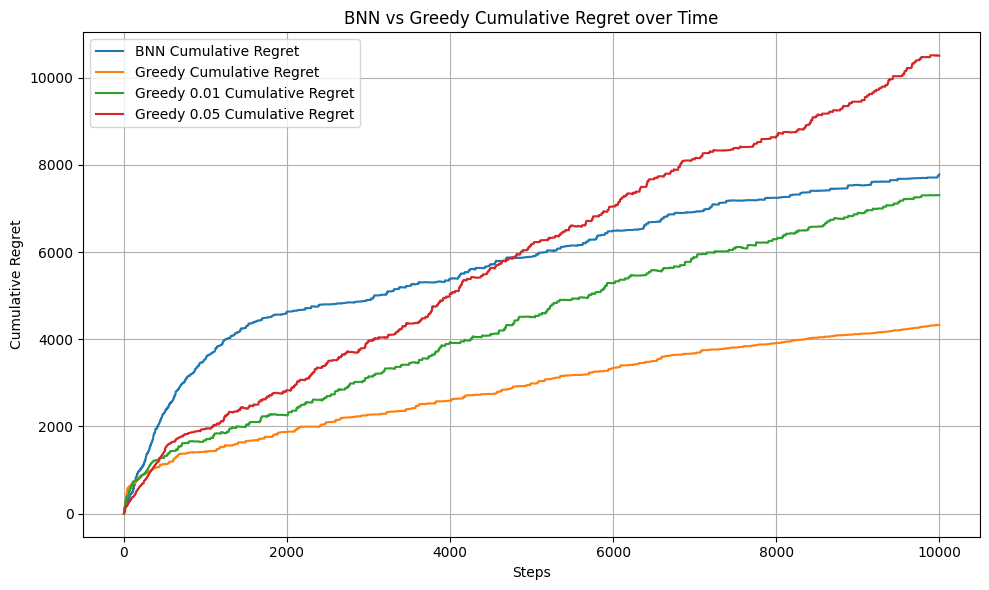

In [21]:
import matplotlib.pyplot as plt

def rl_trainer():
    config = RLConfig
    X, Y = read_data_rl(config.data_dir)

    params = {
        'buffer_size': config.buffer_size,
        'batch_size': config.batch_size,
        'num_batches': config.num_batches,
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init
    }

    bnn_bandit = BNN_Bandit('bnn_bandit', {**params, 'n_samples':2, 'epsilon':0}, X, Y)
    greedy_bandit = Greedy_Bandit('greedy_bandit', {**params, 'n_samples':1, 'epsilon':0}, X, Y)
    greedy_bandit_001 = Greedy_Bandit('greedy_bandit_001', {**params, 'n_samples':1, 'epsilon':0.01}, X, Y)
    greedy_bandit_005 = Greedy_Bandit('greedy_bandit_005', {**params, 'n_samples':1, 'epsilon':0.05}, X, Y)
    
    
    training_steps = config.training_steps
    print(f"Initialising training on {device}...")
    training_data_len = len(X)
    for step in tqdm(range(training_steps)):
        mushroom = np.random.randint(training_data_len)
        bnn_bandit.update(mushroom)
        greedy_bandit.update(mushroom)
        greedy_bandit_001.update(mushroom)
        greedy_bandit_005.update(mushroom)
        
        bnn_bandit.scheduler.step()
        greedy_bandit.scheduler.step()
        greedy_bandit_001.scheduler.step()
        greedy_bandit_005.scheduler.step()

    # Plot cumulative regret
    plt.figure(figsize=(10, 6))
    plt.plot(bnn_bandit.cumulative_regrets, label='BNN Cumulative Regret')
    plt.plot(greedy_bandit.cumulative_regrets, label='Greedy Cumulative Regret')
    plt.plot(greedy_bandit_001.cumulative_regrets, label='Greedy 0.01 Cumulative Regret')
    plt.plot(greedy_bandit_005.cumulative_regrets, label='Greedy 0.05 Cumulative Regret')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Regret')
    plt.title('BNN vs Greedy Cumulative Regret over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


rl_trainer()